# Normalizing flows: binary classification with input estimation

## Load packages

In [2]:
using Random
using LinearAlgebra
using PyPlot
using Distributions
using BenchmarkTools
using ProgressMeter
using Optim
using Revise

using ReactiveMP
using GraphPPL
using Rocket;

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278


## Generate data

In [43]:
function generate_data(nr_samples::Int64)

    # sample weights
    w = rand(nr_samples,2)

    # sample appraisal
    y = zeros(Float64, nr_samples)
    for k = 1:nr_samples
        if w[k,1] > 0.6 && w[k,1] < 0.9 && w[k,2] < 0.4 && w[k,2] > 0.1
            y[k] = 1.0
        elseif w[k,1] < 0.5 || w[k,2] > 0.5 
            y[k] = 0.0
        else
            y[k] = 1.0 * (rand() > 0.5)
        end
    end

    # return data
    return y, w

end;

In [44]:
data_y, data_x = generate_data(200);

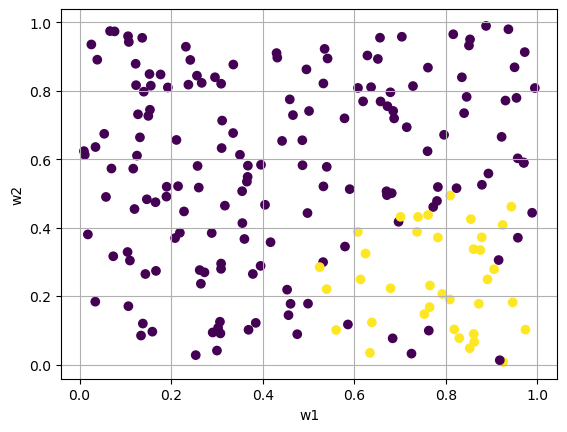

In [45]:
plt.scatter(data_x[:,1], data_x[:,2], c=data_y)
plt.grid()
plt.xlabel("w1")
plt.ylabel("w2");

## Model specification

In [46]:
@model function flow_classifier(nr_samples::Int64, params)
    
    # initialize variables
    x_lat  = randomvar(nr_samples)
    y_lat1 = randomvar(nr_samples)
    y_lat2 = randomvar(nr_samples)
    y      = datavar(Float64, nr_samples)
    x      = datavar(Vector{Float64}, nr_samples)

    # specify model
    model = FlowModel( (NiceLayer(         PlanarMap(params[1],  params[2],  params[3])),
                        ReverseNiceLayer(  PlanarMap(params[4],  params[5],  params[6])),
                        NiceLayer(         PlanarMap(params[7],  params[8],  params[9])),
                        ReverseNiceLayer(  PlanarMap(params[10], params[11], params[12]))))
    meta  = FlowMeta(model)

    # specify observations
    for k = 1:nr_samples

        # specify latent state
        x_lat[k] ~ MvNormalMeanPrecision(x[k], 1e3*diagm(ones(2)))

        # specify transformed latent value
        y_lat1[k] ~ Flow(x_lat[k]) where { meta = meta }
        y_lat2[k] ~ dot(y_lat1[k], [1, 1])

        # specify observations
        y[k] ~ Probit(y_lat2[k]) # default: where { pipeline = RequireInbound(in = NormalMeanPrecision(0, 1.0)) }

    end

    # return variables
    return x_lat, x, y_lat1, y_lat2, y

end;

## Probabilistic Inference

In [47]:
function inference_flow_classifier(data_y::Array{Float64,1}, data_x::Array{Array{Float64,1},1}, params)
    
    # fetch number of samples
    nr_samples = length(data_y)

    # define model
    model, (x_lat, x, y_lat1, y_lat2, y) = flow_classifier(nr_samples, params)

    # initialize free energy
    fe_buffer = nothing
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (fe) -> fe_buffer = fe)

    # update y and x according to observations (i.e. perform inference)
    ReactiveMP.update!(y, data_y)
    ReactiveMP.update!(x, data_x)

    # unsubscribe
    unsubscribe!(fe_sub)
    
    # return the marginal values
    return fe_buffer

end;

In [48]:
function f(params)
    fe = inference_flow_classifier(data_y, [data_x[k,:] for k=1:size(data_x,1)], params)
    return fe
end;

## Experimental validation

In [56]:
res = optimize(f, randn(12), LBFGS(), Optim.Options(store_trace = true, show_trace = true), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     7.194289e+02     2.488695e+03
 * time: 0.0
     1     5.720543e+02     9.083838e+02
 * time: 0.42299985885620117
     2     2.310392e+02     8.356716e+01
 * time: 0.6009998321533203
     3     2.214585e+02     1.037560e+02
 * time: 0.7559998035430908
     4     1.839974e+02     5.230113e+01
 * time: 0.9909999370574951
     5     1.292664e+02     2.087677e+02
 * time: 1.1679999828338623
     6     9.251930e+01     3.214693e+02
 * time: 1.2979998588562012
     7     8.160460e+01     2.777345e+02
 * time: 1.3999998569488525
     8     6.737304e+01     1.270370e+02
 * time: 1.5239999294281006
     9     6.371881e+01     1.683875e+01
 * time: 1.6529998779296875
    10     5.999552e+01     2.315124e+01
 * time: 1.869999885559082
    11     5.751563e+01     3.734843e+01
 * time: 1.9739999771118164
    12     5.492968e+01     7.092754e+01
 * time: 2.1439998149871826
    13     5.030476e+01     3.128149e+01
 * time: 2.315999984741211
    14   

 * Status: success

 * Candidate solution
    Final objective value:     2.720406e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 8.89e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   172  (vs limit Inf)
    Iterations:    147
    f(x) calls:    2985
    ∇f(x) calls:   2985


In [57]:
function uniformpdf(y; xmin = 0, xmax = 1, ymin = 0, ymax = 1)
    indomain = 1.0*(xmin <= y[1] <= xmax)*(ymin <= y[2] <= ymax)
    return indomain/(xmax-xmin)/(ymax-ymin)
end

uniformpdf (generic function with 1 method)

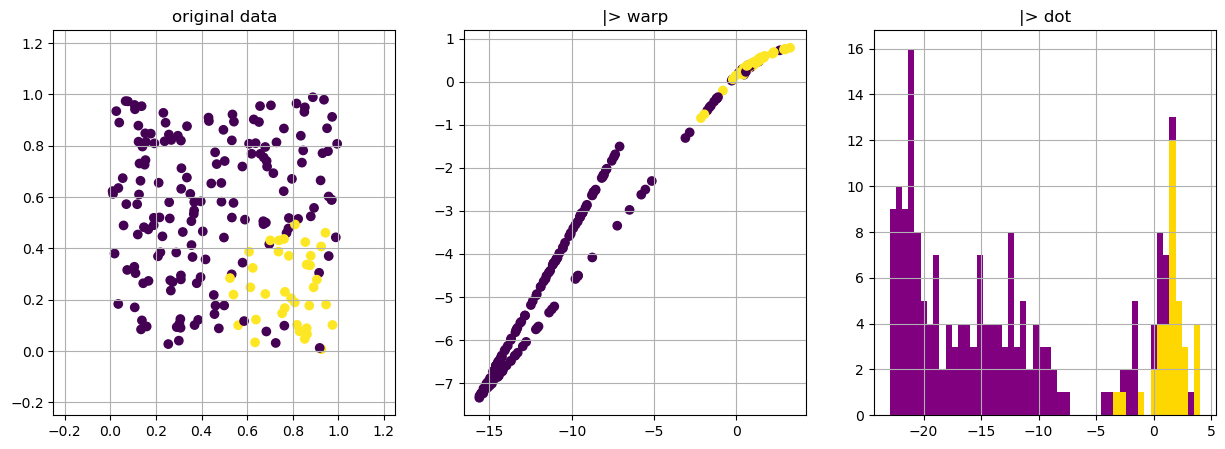

In [58]:
params = Optim.minimizer(res)
inferred_model = FlowModel( (NiceLayer(         PlanarMap(params[1],  params[2],  params[3])),
                             ReverseNiceLayer(  PlanarMap(params[4],  params[5],  params[6])),
                             NiceLayer(         PlanarMap(params[7],  params[8],  params[9])),
                             ReverseNiceLayer(  PlanarMap(params[10], params[11], params[12]))))
trans_data_x_1 = hcat(map((x) -> forward(inferred_model, x), [data_x[k,:] for k=1:size(data_x,1)])...)'
trans_data_x_2 = map((x) -> dot([1, 1], x), [trans_data_x_1[k,:] for k=1:size(data_x,1)])
trans_data_x_2_split = [trans_data_x_2[data_y .== 1.0], trans_data_x_2[data_y .== 0.0]]
fig, ax = plt.subplots(ncols = 3, figsize=(15,5))
ax[1].scatter(data_x[:,1], data_x[:,2], c = data_y)
ax[2].scatter(trans_data_x_1[:,1], trans_data_x_1[:,2], c = data_y)
ax[3].hist(trans_data_x_2_split; stacked=true, bins=50, color = ["gold", "purple"])
ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[1].set_xlim(-0.25,1.25), ax[1].set_ylim(-0.25,1.25)
ax[1].set_title("original data"), ax[2].set_title("|> warp"), ax[3].set_title("|> dot");

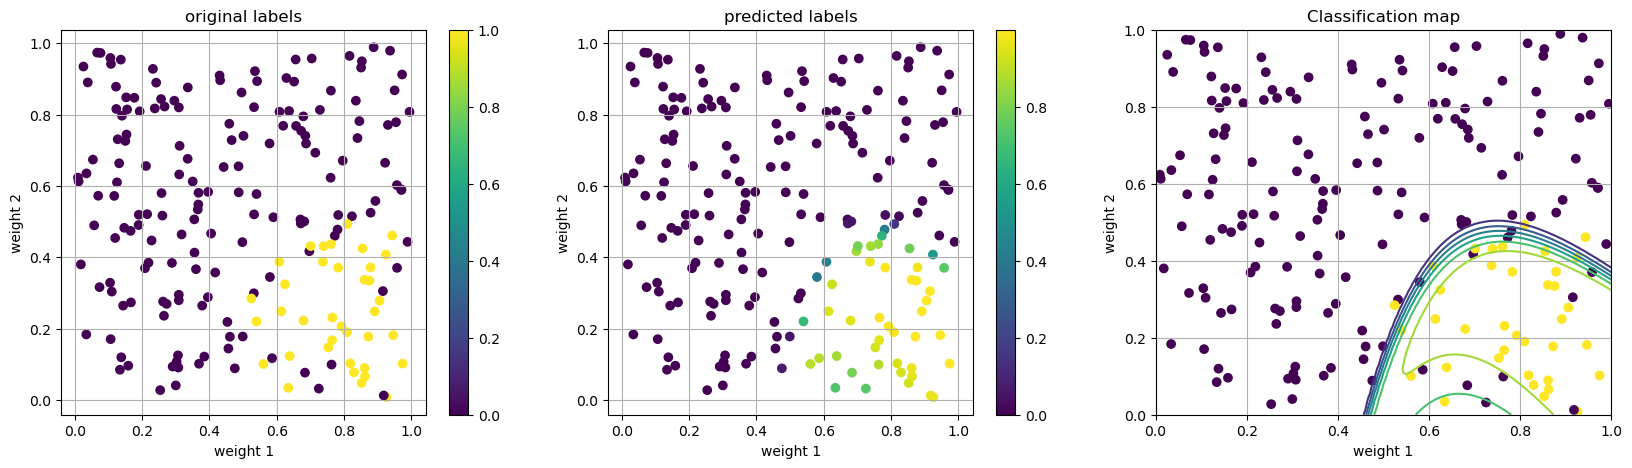

In [59]:
using StatsFuns: normcdf
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1))))
fig, ax = plt.subplots(ncols = 3, figsize=(20,5))
im1 = ax[1].scatter(data_x[:,1], data_x[:,2], c = data_y)
im2 = ax[2].scatter(data_x[:,1], data_x[:,2], c = normcdf.(trans_data_x_2))
ax[3].scatter(data_x[:,1], data_x[:,2], c = data_y)
ax[3].contour(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])
ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[1].set_xlabel("weight 1"), ax[1].set_ylabel("weight 2"), ax[2].set_xlabel("weight 1"), ax[2].set_ylabel("weight 2"), ax[3].set_xlabel("weight 1"), ax[3].set_ylabel("weight 2")
ax[1].set_title("original labels"), ax[2].set_title("predicted labels"), ax[3].set_title("Classification map");

# Weight optimization

In [60]:
struct PointMassFormConstraint2{P}
    point :: P   
end

ReactiveMP.default_form_check_strategy(::PointMassFormConstraint2) = FormConstraintCheckLast()

ReactiveMP.is_point_mass_form_constraint(::PointMassFormConstraint2) = true

function ReactiveMP.constrain_form(pmconstraint::PointMassFormConstraint2, message::Message) 
    is_clamped = ReactiveMP.is_clamped(message)
    is_initial = ReactiveMP.is_initial(message)
    return Message(PointMass(pmconstraint.point), is_clamped, is_initial)
end


In [61]:
@model function flow_classifier_input(input, params)
    
    # initialize variables
    x_lat  = randomvar()
    y_lat1 = randomvar()
    y_lat2 = randomvar()
    xprior = randomvar() where { form_constraint = PointMassFormConstraint2(input)}
    y = datavar(Float64)

    # specify model
    model = FlowModel( (NiceLayer(         PlanarMap(params[1],  params[2],  params[3])),
                        ReverseNiceLayer(  PlanarMap(params[4],  params[5],  params[6])),
                        NiceLayer(         PlanarMap(params[7],  params[8],  params[9])),
                        ReverseNiceLayer(  PlanarMap(params[10], params[11], params[12]))))
    meta  = FlowMeta(model)

    # specify prior on weights
    xprior ~ MvNormalMeanPrecision([0.5,0.5], 1*diagm(ones(2))) where { q = MeanField() }

    # specify latent state
    x_lat ~ MvNormalMeanPrecision(xprior, 1e3*diagm(ones(2))) where { q = MeanField() }

    # specify transformed latent value
    y_lat1 ~ Flow(x_lat) where { meta = meta }
    y_lat2 ~ dot(y_lat1, [1, 1])

    # specify observations
    y ~ Probit(y_lat2) # default where { pipeline = RequireInbound(in = NormalMeanPrecision(0, 1.0)) }

    # return variables
    return x_lat, y_lat1, y_lat2, y

end;

In [62]:
function inference_flow_classifier_input(input, params)

    # define model
    model, (x_lat, y_lat1, y_lat2, y) = flow_classifier_input(input, params)

    # initialize free energy
    fe_buffer = nothing
    
    # subscribe
    fe_sub = subscribe!(score(eltype(input), BetheFreeEnergy(), model), (fe) -> fe_buffer = fe)

    setmarginal!(x_lat, vague(MvNormalMeanPrecision, 2))
    
    # update y and x according to observations (i.e. perform inference)
    for k = 1:10
        ReactiveMP.update!(y, 1.0)
    end

    # unsubscribe
    unsubscribe!(fe_sub)
    
    # return the marginal values
    return fe_buffer

end;

In [63]:
function f_input(input)
    fe = inference_flow_classifier_input(input, params)
    return fe
end;

In [64]:
res = optimize(f_input, rand(2), LBFGS(), Optim.Options(iterations = 100, store_trace = true, show_trace = true), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     1.979256e+00     2.780997e+00
 * time: 0.0
     1     1.958977e+00     5.303785e+00
 * time: 0.017000198364257812
     2     1.944747e+00     9.749381e-01
 * time: 0.02200007438659668
     3     1.942375e+00     1.918356e+00
 * time: 0.0280001163482666
     4     1.918987e+00     2.737900e-01
 * time: 0.03600001335144043
     5     1.918909e+00     1.048034e-02
 * time: 0.042999982833862305
     6     1.918909e+00     4.810052e-04
 * time: 0.051000118255615234
     7     1.918908e+00     5.293517e-06
 * time: 0.0559999942779541
     8     1.918909e+00     7.417078e-06
 * time: 0.06100010871887207
     9     1.918909e+00     4.254825e-06
 * time: 0.06800007820129395
    10     1.918909e+00     1.210636e-06
 * time: 0.07300019264221191
    11     1.918909e+00     9.351893e-06
 * time: 0.0840001106262207
    12     1.918909e+00     5.665205e-06
 * time: 0.08899998664855957
    13     1.918909e+00     1.394278e-05
 * time: 0.0940001010894

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.918909e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 4.85e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.71e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.85e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.05e-10 ≰ 0.0e+00
    |g(x)|                 = 2.93e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    100
    f(x) calls:    387
    ∇f(x) calls:   387


In [65]:
optimum = Optim.minimizer(res)

2-element Array{Float64,1}:
 0.7227994203757497
 0.3843166848578343

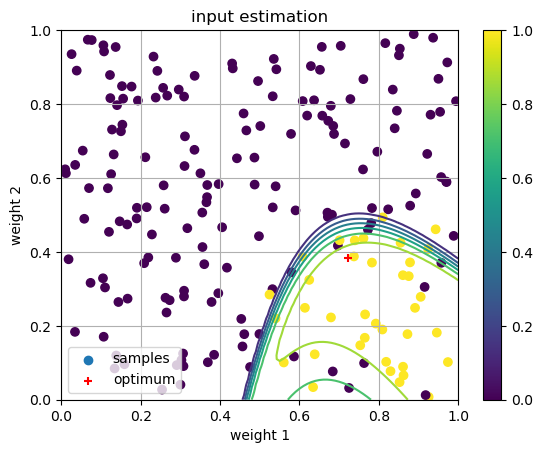

In [66]:
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1))))
plt.scatter(data_x[:,1], data_x[:,2], c = data_y, label="samples")
plt.contour(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
plt.scatter(optimum[1], optimum[2], c = "red", marker = "+", label="optimum")
plt.colorbar()
plt.grid()
plt.legend()
plt.xlabel("weight 1"), plt.ylabel("weight 2"), plt.title("input estimation");

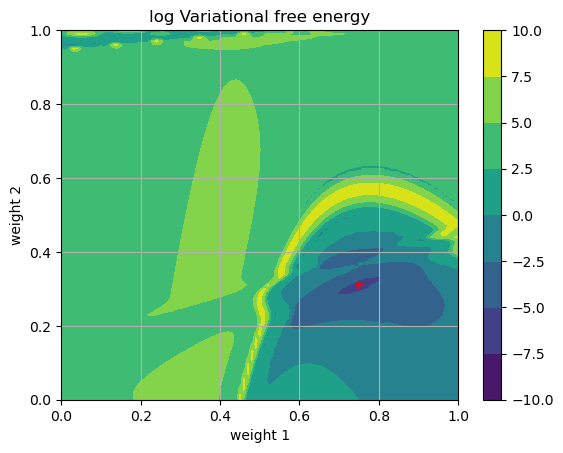

In [67]:
output_range = map((x) -> f_input([x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1)))
output_range[isnan.(output_range)] .= Inf
optimum = minimum(output_range)
im = plt.contourf(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', log.(output_range .- minimum(output_range)))
plt.scatter(collect(0:0.01:1)[findfirst((x) -> x == optimum, output_range)[1]], collect(0:0.01:1)[findfirst((x) -> x == optimum, output_range)[2]], c="red", marker="+")
plt.colorbar(im)
plt.grid()
plt.xlabel("weight 1"), plt.ylabel("weight 2")
plt.title("log Variational free energy");